# Architecture

![Screenshot](./flow_diagram.png)

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader #To load the csv file (data containing companys faq)
from langchain_huggingface import HuggingFaceEmbeddings # Load the  embedding model from huggingface
from langchain_chroma import Chroma #Vectorstore to store the embedded vectors
from langchain_core.prompts import PromptTemplate
from langchain.chains import create_retrieval_chain # "Combines a retriever (to fetch docs) with the 'create_stuff_document_chain' to automate end-to-end retrieval + answering."
from langchain.chains.combine_documents import create_stuff_documents_chain #"Formats retrieved documents + question into a prompt and passes it to the LLM for answering."
from langchain_core.tools import tool # To create a custom tool
from langchain_community.tools import DuckDuckGoSearchRun #Search user queries Online

import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
load_dotenv()

True

## Step-1 Load the data (company_Q1.csv)

#### load the CSV file that Contains the FAQ question regarding the company

In [2]:
file_path = "./company_QA.csv" #Path to the file
loader = CSVLoader(file_path=file_path) #CSVLoader to load the CSV file
docs = []
for doc in loader.lazy_load(): #Perfom lazy load
    docs.append(doc)


In [3]:
len(docs) # Total number of document object

59

In [4]:
docs[0] #first document object

Document(metadata={'source': './company_QA.csv', 'row': 0}, page_content="Question: Where is the company's headquarters located?\nAnswer: Our headquarters is located in San Francisco, California. Nestled in the vibrant downtown area, it provides easy access to public transport and major city landmarks.")

### Note : No need to performing chunking since each document object is a single row of the CSV file

## Step-2 Load the LLM and Embedding model from HuggingFace

In [5]:
# # Load the Mistral 7b model 
# repo_id = "codellama/CodeLlama-7b-hf"
# api_key = "" #Api key to access the hugging face(Please use your own API Key)
# llm = HuggingFaceEndpoint(
#     repo_id = repo_id,
#     huggingfacehub_api_token=api_key,
#     temperature = 0.3, 
#     max_new_tokens=200 ,  # Max number of tokens to generate in the final output

# )
# model = ChatHuggingFace(llm=llm)
# #Test the model if working properly
# # model.invoke("hey how are you")

In [6]:
# from langchain.llms import HuggingFaceHub
# from langchain.chat_models import ChatHuggingFace

# repo_id = "codellama/CodeLlama-7b-hf"
# api_key = ""

# llm = HuggingFaceHub(
#     repo_id=repo_id,
#     huggingfacehub_api_token=api_key,
#     model_kwargs={"temperature": 0.3, "max_new_tokens": 200}
# )

# model = ChatHuggingFace(llm=llm)

# # Test
# response = model.invoke("Who is Messi?")
# print(response)

In [7]:
from langchain_groq import ChatGroq
model = ChatGroq(model_name = "Llama-3.3-70b-Versatile",max_tokens= 200) # Load the Groq Model

In [8]:
#Loading the embedding model 
embedding_model = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")

## Step-3 Creating a Vectorstore and a retriever

#### a. Chroma vector store to store the embedding vectors
#### b. retriever to fetch the relevant documents based on user query from vectorstore

In [9]:
# Creating and added documents to vector store
db = Chroma.from_documents(docs,  #Document object 
                            embedding_model) #Huggingface embedding model

In [10]:
# Creating a retriever
retriever = db.as_retriever(search_type = "mmr"  #Maximux-marginal-relevance 
                            ,search_kwargs = {'k':2,'lambda_mult':0.4} # 'k': select top 2 similar documents and 'lambda_mult': for diverse documents 
                            )

In [11]:
# Test how well is the retriever working 
query = "what are the types of leaves that employee can take ?"
result = retriever.invoke(query)
for index , res in enumerate(result):
    print(f"---Document-{index+1}")
    print(res.page_content)

---Document-1
Question: What types of leave are offered besides annual leave?
Answer: We provide: Sick leave (12 days/year), Maternity leave (6 months), Paternity leave (4 weeks), Bereavement leave (5 days)
---Document-2
Question: What is the building's evacuation procedure?
Answer: Evacuation maps are posted throughout the building. In case of an emergency, alarms will sound and staff will direct occupants to the nearest exit.


## Step-4 Creating a prompt template

In [12]:
template = PromptTemplate(
    template = """You are a helpful AI assistance.Please answer the given user question only based on the context provided. 
'context'
{context}
'user question'
{input}""",
input_variables=['context','input']
)

## Step-5 Create a Chain 

#### Creating a RAG_Chain by combining components like 'prompt template' , 'retriever' etc

In [13]:
# To create a chain that "Formats retrieved documents + question into a prompt and passes it to the LLM for answering."
combine_docs_chain = create_stuff_documents_chain(model, template)
# To create a final chain to reterive, format prompt and generate answer 
rag_chain = create_retrieval_chain(retriever, combine_docs_chain) 

In [14]:
# Ask a query to the llm to reg the final response
result = rag_chain.invoke({
    'input':query
})
result['answer']

'The types of leaves that an employee can take are: \n1. Sick leave (12 days/year)\n2. Maternity leave (6 months)\n3. Paternity leave (4 weeks)\n4. Bereavement leave (5 days) \nBesides these, annual leave is also available.'

## Step-6 Creating tools 

### Tool A. VectorStore Retriever tool (Convert the rag_chain into a tool)

#### Redirect to this tool if the user queries is regarding the companies HR Policy

### Tool B. DuckDuckSeach Tool

#### Redirect to this tool if the user query is general 


In [15]:
@tool
def retrieve_vectorstore_tool(query:str)->str:
    """RAG solution for a companys HR Policy FAQ"""
    return rag_chain.invoke({'input':query})

In [16]:
search = DuckDuckGoSearchRun()
@tool
def duckducksearch_tool(query:str)->str:
    """Perform duckduck search when user query is other then companies HR policy"""
    return search.invoke(query)


## Step-7 Bind the llm with tools

In [17]:
tools = [retrieve_vectorstore_tool,duckducksearch_tool]
llm_with_tools = model.bind_tools(tools=tools)

In [18]:
llm_with_tools.invoke(query).tool_calls

[{'name': 'retrieve_vectorstore_tool',
  'args': {'query': 'types of leaves that employee can take'},
  'id': 'call_wg1b',
  'type': 'tool_call'}]

## Step-8 Define the langgraph Workflow

In [19]:
from typing_extensions import Annotated,TypedDict #Annotated for labelling and TypeDict to maintain graph state 
from langchain_core.messages import AnyMessage #Human message or Ai Message
from langgraph.graph.message import add_messages  ## Reducers in Langgraph 

#Schema info that flows through the nodes
class state(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

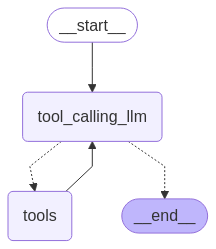

In [20]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode #specialized node designed to execute tools within our workflow.
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display #to visualize the Graph



#Function that decides which tool to use for serving the userquery
def tool_calling_llm(state:state) ->state:
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

# Initialize the StateGraph
builder = StateGraph(state_schema=state)

#Adding Nodes
builder.add_node('tool_calling_llm',tool_calling_llm) #returns the tools that is to be used
builder.add_node('tools',ToolNode(tools=tools)) #Uses the tool specified to fetch result

#Adding Edges
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    # If the latest message from AI is a tool call -> tools_condition routes to tools
    # If the latest message from AI is a not a tool call -> tools_condition routes to LLM, then generate final response and END
    tools_condition
)
builder.add_edge('tools','tool_calling_llm')

#Compile the graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [21]:
response = graph.invoke({
    'messages': query
})

In [22]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

what are the types of leaves that employee can take ?
================================== Ai Message ==================================
Tool Calls:
  retrieve_vectorstore_tool (call_hzm6)
 Call ID: call_hzm6
  Args:
    query: types of leaves for employees in company HR policy
================================= Tool Message =================================
Name: retrieve_vectorstore_tool

{'input': 'types of leaves for employees in company HR policy', 'context': [Document(id='0d2424e4-c67b-4da9-802f-451e3b2f1f7d', metadata={'row': 48, 'source': './company_QA.csv'}, page_content='Question: What types of leave are offered besides annual leave?\nAnswer: We provide: Sick leave (12 days/year), Maternity leave (6 months), Paternity leave (4 weeks), Bereavement leave (5 days)'), Document(id='a9bf6caa-59d0-4e05-9ab1-d4e3e8011f71', metadata={'row': 41, 'source': './company_QA.csv'}, page_content="Question: What is 

In [23]:
print(f'User: {query}\n')
print(f"AI :{response['messages'][-1].content}")

User: what are the types of leaves that employee can take ?

AI :The company offers various types of leaves to its employees, including sick leave, maternity leave, paternity leave, and bereavement leave, in addition to annual leave. The specifics of these leaves are as follows: 
1. Sick leave: 12 days per year
2. Maternity leave: 6 months
3. Paternity leave: 4 weeks
4. Bereavement leave: 5 days
